In [2]:
# load in packages
from itertools import combinations

## from test_results import valid_results, test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
# load in the data
train_data = pd.read_csv('training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [4]:
# check number of missing values per column
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [5]:
test_data = pd.read_csv('Test.csv')
test_data.head(7)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2
5,13,Yes,0,0,32.566788,-1.684550,2,1,2,1
6,19,No,0,2,29.833921,-1.078506,1,2,3,2


In [6]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
print(train_data['Promotion'].value_counts())
print(train_data['purchase'].value_counts())

Yes    42364
No     42170
Name: Promotion, dtype: int64
0    83494
1     1040
Name: purchase, dtype: int64


[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC100F160>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC192C320>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC1B5C588>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC1D87860>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC23C0400>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC26949E8>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC28C2C50>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAC2AEFEB8>


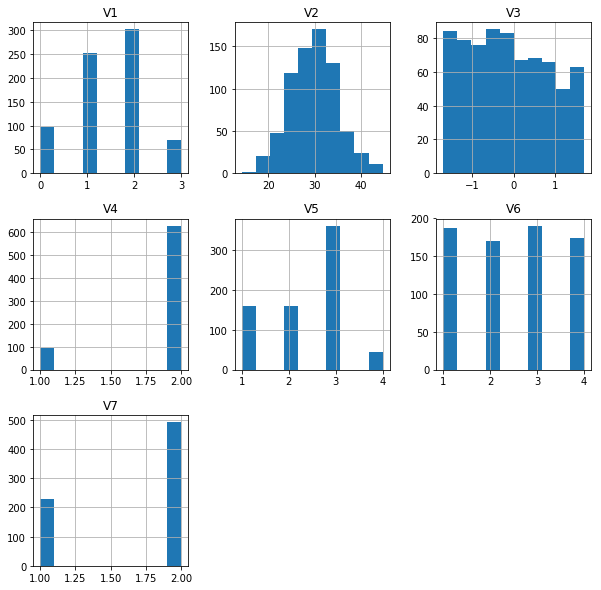

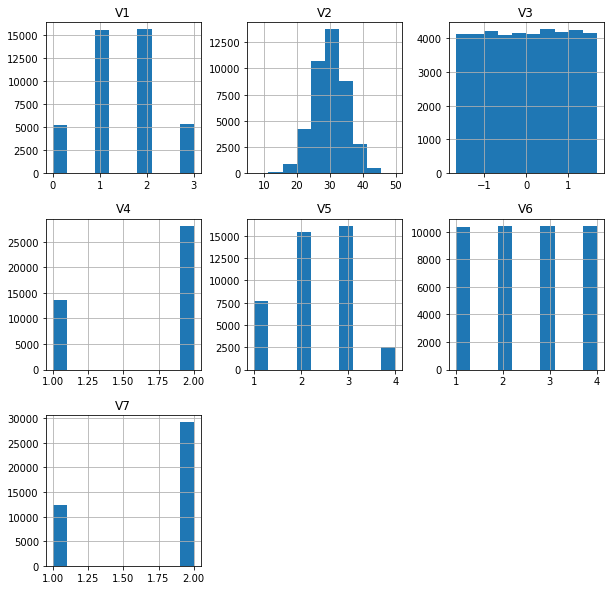

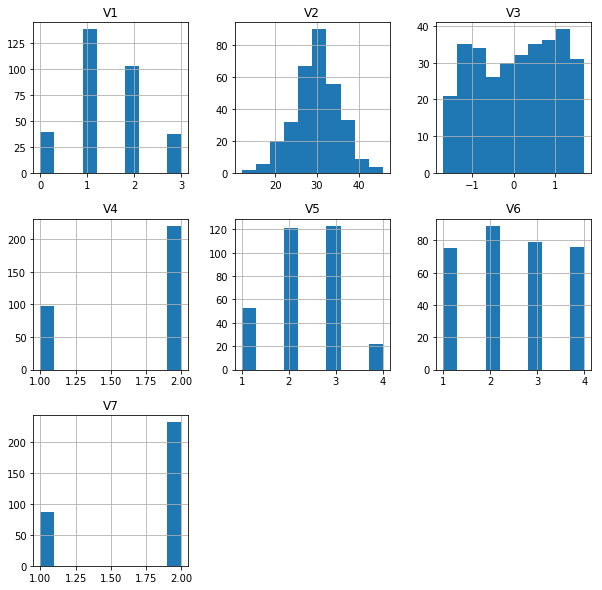

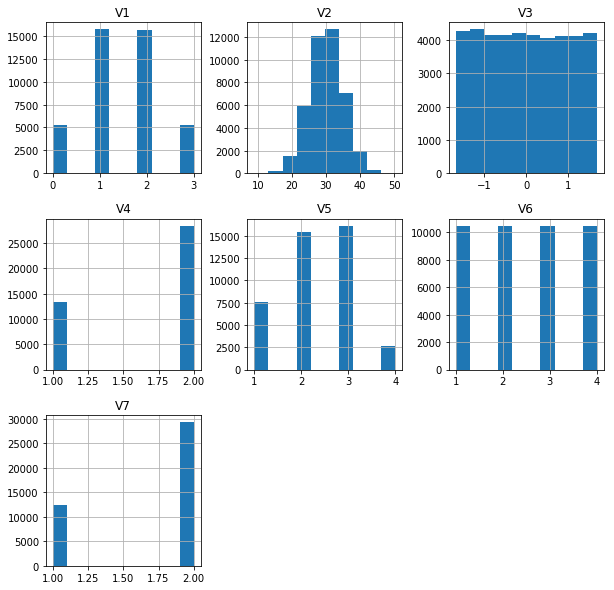

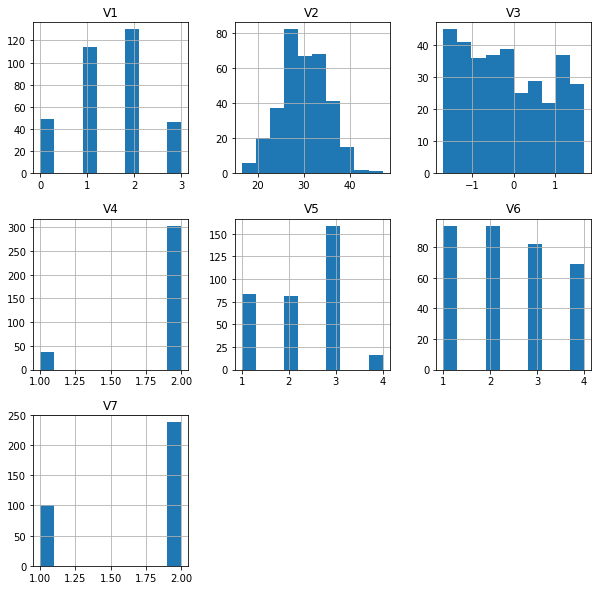

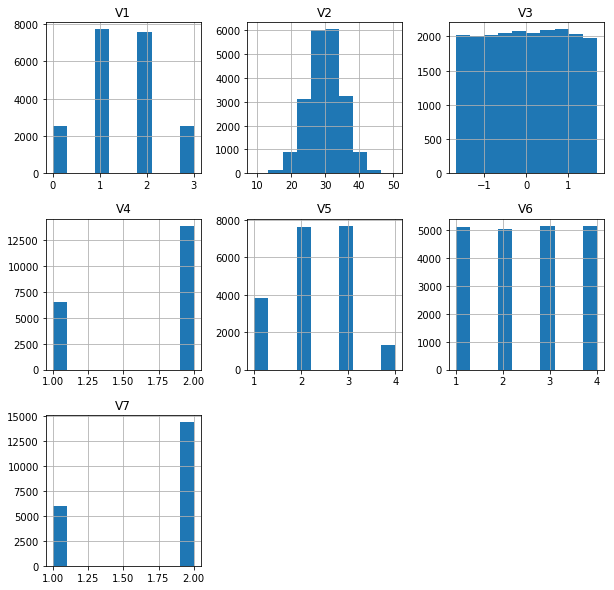

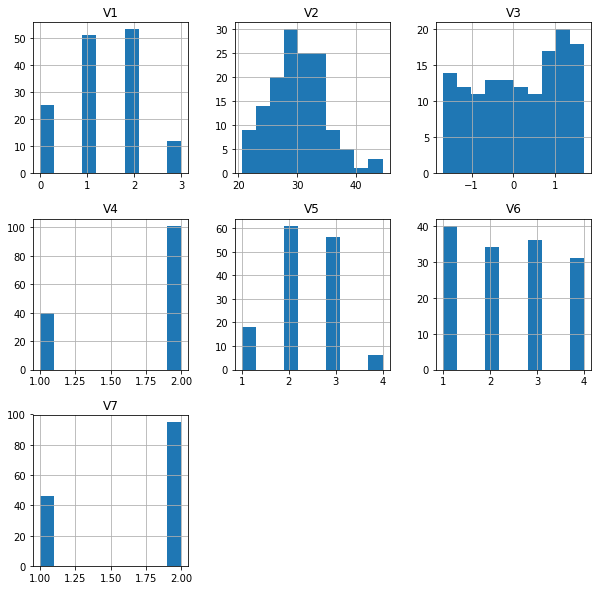

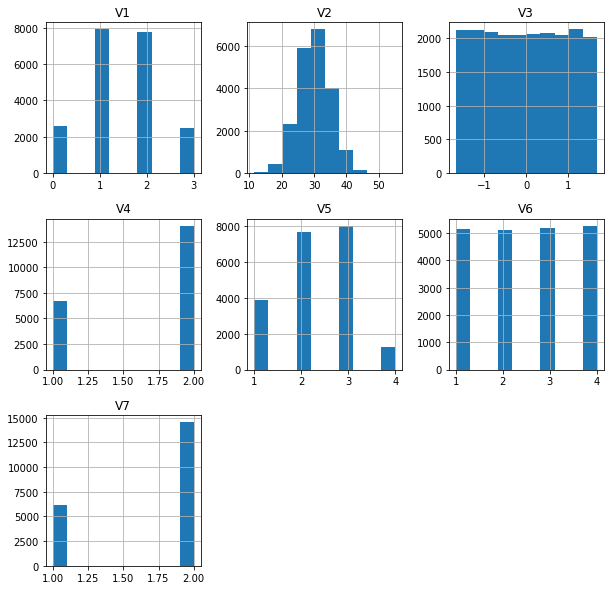

In [7]:
print(train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10)))
print(train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10)))
print(train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10)))
print(train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10)))
print(test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==1)][features].hist(figsize=(10,10)))
print(test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==0)][features].hist(figsize=(10,10)))
print(test_data[(test_data['Promotion']=='No') & (test_data['purchase']==1)][features].hist(figsize=(10,10)))
print(test_data[(test_data['Promotion']=='No') & (test_data['purchase']==0)][features].hist(figsize=(10,10)))

In [15]:
# Check sample size needed for control and treatment groups
NormalIndPower().solve_power(effect_size = proportion_effectsize(0.0096, 0.015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

In [9]:
# calculate our current treatment group size
print(train_data[train_data['Promotion']=='Yes'].shape[0])

# calculate our current control group size
print(train_data[train_data['Promotion']=='No'].shape[0])

42364
42170


In [10]:
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('Test.csv')

In [70]:
combined_data = pd.concat([train_data,test_data],axis = 0)
print(combined_data.head(10))
print(len(combined_data))
print(combined_data['Promotion'].value_counts())

   ID Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0   1        No         0   2  30.443518 -1.165083   1   1   3   2
1   3        No         0   3  32.159350 -0.645617   2   3   2   2
2   4        No         0   2  30.431659  0.133583   1   1   4   2
3   5        No         0   0  26.588914 -0.212728   2   1   4   2
4   8       Yes         0   3  28.044332 -0.385883   1   1   2   2
5   9        No         0   1  41.189415 -0.905350   2   4   4   1
6  11        No         0   1  40.690409  1.085939   2   2   1   2
7  14        No         0   2  25.971529 -1.424817   1   3   3   2
8  15       Yes         0   2  31.930423  0.393317   2   3   1   2
9  16        No         0   1  27.474650  0.566472   2   2   3   2
126184
Yes    63112
No     63072
Name: Promotion, dtype: int64


In [16]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [29]:
response = []

for index, row in test_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
test_data['response'] = response

In [23]:
print(train_data['Promotion'].value_counts())

Yes    42364
No     42170
Name: Promotion, dtype: int64


In [30]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

##train_treatment, train

# generate features and labels

Y_test = test_data['response']
X_test = test_data[features]

Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

print(Y_train.value_counts())
print(Y_valid.value_counts())

0.0    67047
1.0      580
Name: response, dtype: int64
0.0    16766
1.0      141
Name: response, dtype: int64


In [18]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.891992	validation_1-auc:0.645481
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.898054	validation_1-auc:0.653202
[2]	validation_0-auc:0.906917	validation_1-auc:0.65697
[3]	validation_0-auc:0.915775	validation_1-auc:0.658408
[4]	validation_0-auc:0.934996	validation_1-auc:0.655914
[5]	validation_0-auc:0.935649	validation_1-auc:0.651876
[6]	validation_0-auc:0.935016	validation_1-auc:0.654039
[7]	validation_0-auc:0.943776	validation_1-auc:0.655699
[8]	validation_0-auc:0.944752	validation_1-auc:0.650929
[9]	validation_0-auc:0.950239	validation_1-auc:0.648446
[10]	validation_0-auc:0.950787	validation_1-auc:0.648789
[11]	validation_0-auc:0.957777	validation_1-auc:0.648527
[12]	validation_0-auc:0.959635	validation_1-auc:0.645952
[13]	validation_0-auc:0.961191	validation_1-auc:0.644991
[14]	validation_0-auc:0.963264	validation_1-auc:0.644359

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [31]:
valid_pred = model.predict_proba(X_valid, ntree_limit=model.best_ntree_limit)

train_pred = model.predict_proba(X_train_upsamp, ntree_limit=model.best_ntree_limit)

test_pred = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


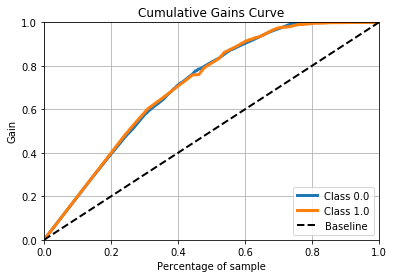

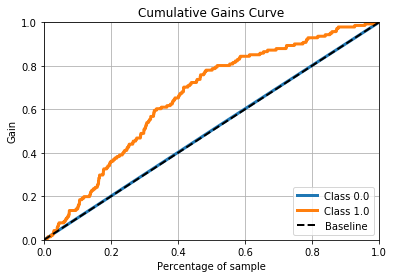

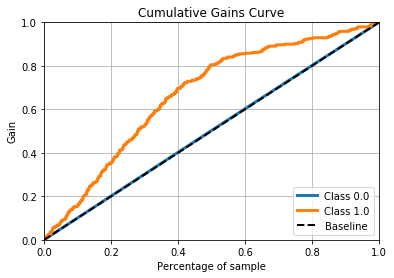

In [32]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(Y_train_upsamp,train_pred)
skplt.metrics.plot_cumulative_gain(Y_valid, valid_pred)
skplt.metrics.plot_cumulative_gain(Y_test, test_pred)

plt.show()

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


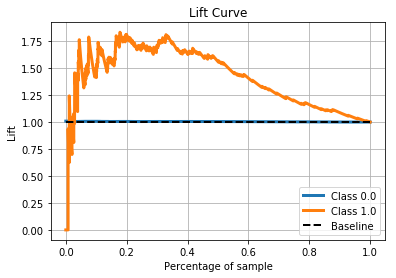

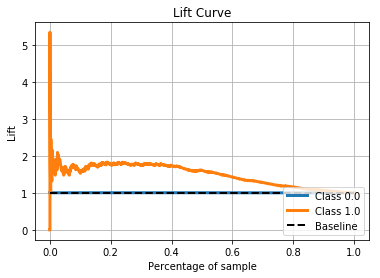

In [33]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_lift_curve(Y_valid, valid_pred)
skplt.metrics.plot_lift_curve(Y_test, test_pred)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
auc_training = roc_auc_score(Y_train_upsamp, train_pred[:,1])
print("AUC training:", auc_training)

auc_valid = roc_auc_score(Y_valid, valid_pred[:,1])
print("AUC validation:", auc_valid)

auc_test = roc_auc_score(Y_test, test_pred[:,1])
print("AUC testing:", auc_test)

AUC training: 0.9157746136193592
AUC validation: 0.6584080158849005
AUC testing: 0.6699341329803593


## Separate Model for Treatment and Control groups using Logistic Regression

In [20]:
treatment_data = train_data[train_data["Promotion"] == 'Yes']
Control_data = train_data[train_data["Promotion"] == 'No']

Y_treatment = treatment_data['purchase']
X_treatment = treatment_data[features]

Y_control = Control_data['purchase']
X_control = Control_data[features]

print(len(X_treatment))
print(Y_treatment.value_counts())

print(len(X_control))
print(Y_control.value_counts())


42364
0    41643
1      721
Name: purchase, dtype: int64
42170
0    41851
1      319
Name: purchase, dtype: int64


In [39]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_treat_upsamp, Y_treat_upsamp = sm.fit_sample(X_treatment, Y_treatment)
    
X_treat_upsamp = pd.DataFrame(X_treat_upsamp, columns=features)

Y_treat_upsamp = pd.Series(Y_treat_upsamp)

X_control_upsamp, Y_control_upsamp = sm.fit_sample(X_control, Y_control)
    
X_control_upsamp = pd.DataFrame(X_control_upsamp, columns=features)

Y_control_upsamp = pd.Series(Y_control_upsamp)

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [40]:
## Test data for model evaluation and predictions
treatment_test = test_data[train_data["Promotion"] == 'Yes']
Control_test = test_data[train_data["Promotion"] == 'No']

Y_test_treatment = treatment_test['purchase']
X_test_treatment = treatment_test[features]

Y_test_control = Control_test['purchase']
X_test_control = Control_test[features]

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
from sklearn.linear_model import LogisticRegression
## Training the treatment model without upsample
model_control = LogisticRegression()
model_control.fit(X_control_upsamp, Y_control_upsamp)

## Training the treatment model without upsample
model_treatment = LogisticRegression()
model_treatment.fit(X_treat_upsamp, Y_treat_upsamp)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
## Making predictions on the test datasets for treatment and control without upsampling
control_test_pred = model_control.predict_proba(X_test_control)
treatment_test_pred = model_treatment.predict_proba(X_test_treatment)

In [43]:
## AUC calculations
from sklearn.metrics import roc_auc_score
auc_treatment = roc_auc_score(Y_test_treatment, treatment_test_pred[:,1])
print("Treatment AUC score:", auc_treatment)

auc_control = roc_auc_score(Y_test_control, control_test_pred[:,1])
print("Control AUC score:", auc_control)

Treatment AUC score: 0.5966968955555308
Control AUC score: 0.5197999396184856


C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


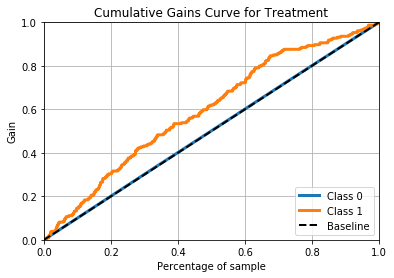

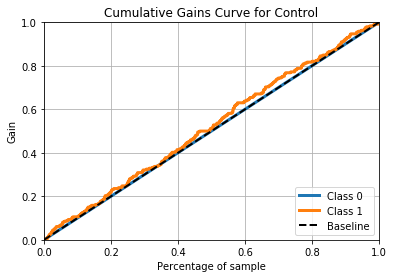

In [47]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(Y_test_treatment, treatment_test_pred,title = "Cumulative Gains Curve for Treatment")
skplt.metrics.plot_cumulative_gain(Y_test_control, control_test_pred, title = "Cumulative Gains Curve for Control")
plt.show()

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


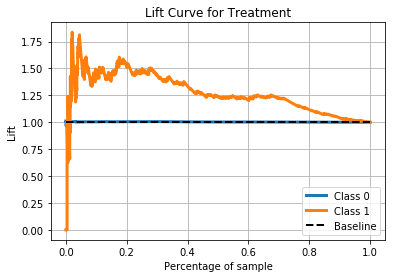

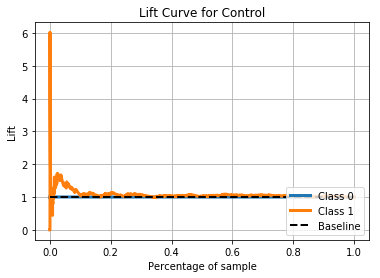

In [48]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_lift_curve(Y_test_treatment, treatment_test_pred,title = "Lift Curve for Treatment")
skplt.metrics.plot_lift_curve(Y_test_control, control_test_pred, title = "Lift Curve for Control")
plt.show()

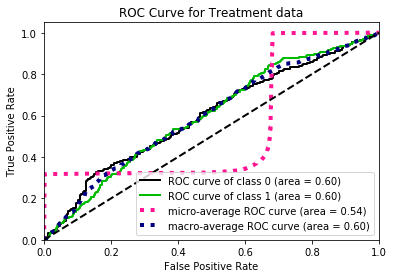

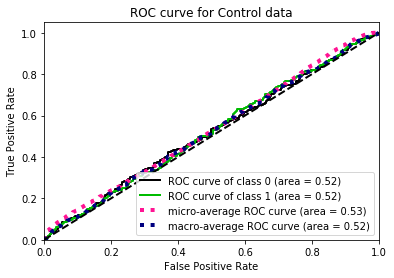

In [46]:
skplt.metrics.plot_roc(Y_test_treatment, treatment_test_pred, title = "ROC Curve for Treatment data")
skplt.metrics.plot_roc(Y_test_control, control_test_pred, title = "ROC curve for Control data")
plt.show()

In [38]:
# Train an xgboost model for treatment group
eval_set = [(X_treat_upsamp, Y_treat_upsamp), (X_test_treatment, Y_test_treatment)]
model_treat = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model_treat.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

NameError: name 'X_train_upsamp' is not defined

In [32]:
# Train an xgboost model for control group
eval_set = [(X_control_upsamp, Y_control_upsamp), (X_test_control, Y_test_control)]
model_control = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model_control.fit(X_control_upsamp, Y_control_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.890152	validation_1-auc:0.504407
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.914933	validation_1-auc:0.510216
[2]	validation_0-auc:0.932581	validation_1-auc:0.513014
[3]	validation_0-auc:0.932212	validation_1-auc:0.51438
[4]	validation_0-auc:0.944257	validation_1-auc:0.516057
[5]	validation_0-auc:0.96081	validation_1-auc:0.52007
[6]	validation_0-auc:0.967477	validation_1-auc:0.51435
[7]	validation_0-auc:0.971747	validation_1-auc:0.503735
[8]	validation_0-auc:0.980571	validation_1-auc:0.50432
[9]	validation_0-auc:0.984676	validation_1-auc:0.503399
[10]	validation_0-auc:0.985404	validation_1-auc:0.50091
[11]	validation_0-auc:0.986039	validation_1-auc:0.506646
[12]	validation_0-auc:0.987037	validation_1-auc:0.502712
[13]	validation_0-auc:0.987343	validation_1-auc:0.503301
[14]	validation_0-auc:0.988975	validation_1-auc:0.504908
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [33]:
## Making predictions on the test datasets for treatment and control without upsampling
control_test_pred = model_control.predict_proba(X_test_control)
treatment_test_pred = model_treat.predict_proba(X_test_treatment)

NameError: name 'model_treat' is not defined

In [34]:
## Making predictions on the test datasets for treatment and control without upsampling
control_pred = model_control.predict(X_test_control)
treatment_pred = model_treat.predict(X_test_treatment)

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


NameError: name 'model_treat' is not defined

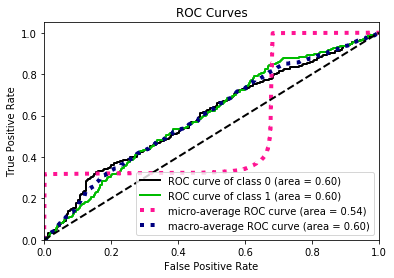

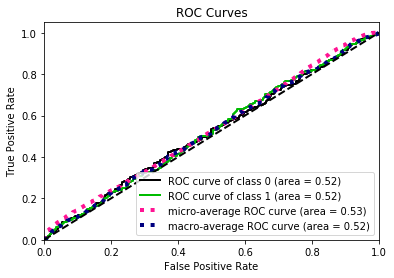

In [31]:
skplt.metrics.plot_roc(Y_test_treatment, treatment_test_pred)
skplt.metrics.plot_roc(Y_test_control, control_test_pred)
plt.show()

In [29]:
## AUC calculations
from sklearn.metrics import roc_auc_score
auc_treatment = roc_auc_score(Y_test_treatment, treatment_test_pred[:,1])
print("Treatment AUC score:", auc_treatment)

auc_control = roc_auc_score(Y_test_control, control_test_pred[:,1])
print("Control AUC score:", auc_control)

Treatment AUC score: 0.5966968955555308
Control AUC score: 0.5197999396184856


C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


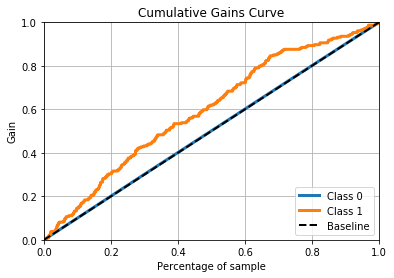

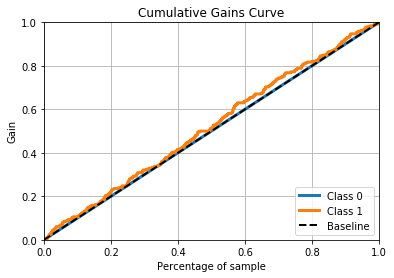

In [30]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(Y_test_treatment, treatment_test_pred)
skplt.metrics.plot_cumulative_gain(Y_test_control, control_test_pred)
plt.show()

C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


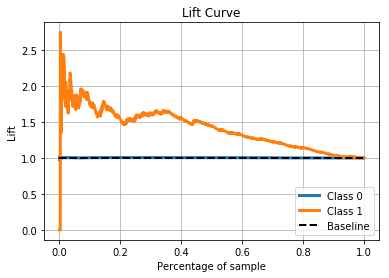

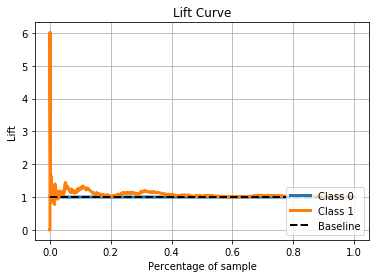

In [63]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_lift_curve(Y_test_treatment, treatment_test_pred)
skplt.metrics.plot_lift_curve(Y_test_control, control_test_pred)
plt.show()

## Test of Significance between Treatment and Control groups: Test of Proportions

In [71]:
combined_data = pd.concat([train_data,test_data],axis = 0)
print(combined_data.head(10))
print(len(combined_data))
print(combined_data['Promotion'].value_counts())

   ID Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0   1        No         0   2  30.443518 -1.165083   1   1   3   2
1   3        No         0   3  32.159350 -0.645617   2   3   2   2
2   4        No         0   2  30.431659  0.133583   1   1   4   2
3   5        No         0   0  26.588914 -0.212728   2   1   4   2
4   8       Yes         0   3  28.044332 -0.385883   1   1   2   2
5   9        No         0   1  41.189415 -0.905350   2   4   4   1
6  11        No         0   1  40.690409  1.085939   2   2   1   2
7  14        No         0   2  25.971529 -1.424817   1   3   3   2
8  15       Yes         0   2  31.930423  0.393317   2   3   1   2
9  16        No         0   1  27.474650  0.566472   2   2   3   2
126184
Yes    63112
No     63072
Name: Promotion, dtype: int64


In [73]:
## Comparing control with mens email treatment and testing for significance for conversion rate
import statsmodels.api as sm

purchase_nopromotion = (combined_data.query('Promotion=="No"')['purchase']==1).sum()
purchase_promotion = (combined_data.query('Promotion=="Yes"')['purchase']==1).sum()
n_nopromotion = (combined_data['Promotion']=='No').sum()
n_promotion =(combined_data['Promotion']=='Yes').sum()

print((purchase_nopromotion, purchase_promotion, n_nopromotion, n_promotion))

z_score, p_value = sm.stats.proportions_ztest([purchase_promotion, purchase_nopromotion], [n_promotion, n_nopromotion], alternative='larger')
print((z_score, p_value))

(460, 1060, 63072, 63112)
(15.4707792708861, 2.7320780928618836e-54)


In [82]:
print(combined_data[combined_data['Promotion'] == 'Yes']['purchase'].value_counts())

0    62052
1     1060
Name: purchase, dtype: int64


## Business case examples

In [ ]:
## Case 1:
## Company trying to get a revenue of $5000 from the campaign with least population possible
## Get best customers who gives best lift from the predictive model

Total Revenue = $5000
Contribution per target = $10
Number of targets in the population = 1000
Total Population = 60000
Expected targets for $5000 = 5000/10 = 500
Expected Gain = 500/1000 = 0.5
Percentage of population to reach from cumulative curve = Top 30% of the population with highest probability of response

In [ ]:
## Case 2:
## Company trying to get a profit of $2500 from the campaign with least population possible
## Get best customers who gives best lift from the predictive model

Total Profit = $2300
Contribution per target = $10
Number of targets in the population = 40000
Total Population = 60000
##Expected targets for $5000 = 5000/10 = 500
Expected Gain for 0.67% of population = 0.83
Total revenue = 0.83*1000 = 830 * 10 = 8300
Total cost = 40000*0.15 = 600
Total Profit = 8300 - 600 = $2300 nearly equal to $2500

## An optimization function for profit will give us the exact population to target to get the required profits